In [1]:
import jax.numpy as jnp
import numpy as np
import scipy
from scipy.interpolate import interp1d
import h5py
import matplotlib.pyplot as plt 
import os 
import jax
import time
import jax.numpy as jnp
from train_pybird_emulators.emu_utils import emu_utils as utils 
from pybird.correlator import Correlator    
from classy import Class

## In this notebook we validate the found knots from the decomposition process

### Lets begin with loading in a bank of pre-made Pks on a kk grid

* Here we also define a fiducial covariance which will be used in the validation stage

In [16]:
bpk_file = "/cluster/scratch/areeves/pybird_training_data_bpk_full_narrow/total_data.h5"
with h5py.File(bpk_file, "a") as hdf_file:
    print(hdf_file.keys())
    bpk_array = np.array(hdf_file["bpk"][:])
    pk_array = np.array(hdf_file["pk_lin"][:])
    f1_array = np.array(hdf_file["f1"][:])
    D1_array = np.array(hdf_file["D1"][:])
    params_array = np.array(hdf_file["params"][:])
    kk_array = np.array(hdf_file["kk"][:])
    bpk_reconstructed_array = np.array(hdf_file["bpk_knots_reconstructed"][:])


<KeysViewHDF5 ['D1', 'bpk', 'bpk_knots_reconstructed', 'f1', 'kk', 'params', 'pk_lin']>


In [3]:
#create a correlator engine instance for cimputing the bpk 
resum = True
N = Correlator()
N.set(      {"output": "bPk",
            "multipole": 3,
            "kmax": 0.4,
            "fftaccboost": 2,  # boosting the FFTLog precision (slower, but ~0.1% more precise -> let's emulate this)
            "with_resum": resum,
            "with_exact_time": True,
            "km": 1.0,
            "kr": 1.0,
            "nd": 3e-4,
            "with_emu":False,
            "eft_basis": "eftoflss",
            "with_stoch": True,})

loading loop matrices!


In [4]:
k_arr = np.array([0.001 , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
    0.02  , 0.0225, 0.025 , 0.0275, 0.03  , 0.035 , 0.04  , 0.045 ,
    0.05  , 0.055 , 0.06  , 0.065 , 0.07  , 0.075 , 0.08  , 0.085 ,
    0.09  , 0.095 , 0.1   , 0.105 , 0.11  , 0.115 , 0.12  , 0.125 ,
    0.13  , 0.135 , 0.14  , 0.145 , 0.15  , 0.155 , 0.16  , 0.165 ,
    0.17  , 0.175 , 0.18  , 0.185 , 0.19  , 0.195 , 0.2   , 0.205 ,
    0.21  , 0.215 , 0.22  , 0.225 , 0.23  , 0.235 , 0.24  , 0.245 ,
    0.25  , 0.255 , 0.26  , 0.265 , 0.27  , 0.275 , 0.28  , 0.285 ,
    0.29  , 0.295 , 0.3   , 0.31  , 0.32  , 0.33  , 0.34  , 0.35  ,
    0.36  , 0.37  , 0.38  , 0.39  , 0.4])

nbank = 10000

In [5]:
outdir = os.path.join('/cluster/work/refregier/alexree/frequentist_framework/pybird_emu', 'data', 'eftboss', 'out')
with open(os.path.join(outdir, 'fit_boss_onesky_pk_wc_cmass_ngc_l0.dat')) as f: data_file = f.read()
eft_params_str = data_file.split(', \n')[1].replace("# ", "")
eft_params = {key: float(value) for key, value in (pair.split(': ') for pair in eft_params_str.split(', '))}
print (eft_params)

{'b1': 1.9536, 'c2': 0.5865, 'c4': 0.0, 'b3': -0.3595, 'cct': 0.1821, 'cr1': -0.8417, 'cr2': -0.808, 'ce0': 1.4954, 'ce1': 0.0, 'ce2': -1.6292, 'b2': 0.4147, 'b4': 0.4147}


In [6]:
k_l, k_r =  1e-4, 0.7 #In Mpc/h
kk = np.logspace(-5, 1, 1000)
mask = (kk < k_l) | (kk > k_r)
# mask = np.where((kk>k_l) & (kk<k_r))
kk_ = kk[mask]
#Get covariance matrix at reference cosmology 
z=0.5
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 30, 'z_max_pk': z})
M.compute()

D1, f1 = M.scale_independent_growth_factor(z), M.scale_independent_growth_factor_f(z)
Omega0_m = M.Omega0_m()
pk_lin = np.array([M.pk_lin(k*M.h(), z)*M.h()**3 for k in kk]) # k in Mpc/h, pk in (Mpc/h)^3
ipk_h = interp1d(kk, pk_lin, kind='cubic')

Vs = 3.e10      # ideal volume (in [Mpc/h]^3), > 3 x better than DESI / Euclid (BOSS ~ 3e9, DESI ~ 3e10)
nbar = 2e-3     # ideal nbar (for b1~2) (in [Mpc/h]^3), > 3 x better than DESI / Euclid

cov = utils.get_cov(k_arr, ipk_h, eft_params["b1"], f1, mult=3, nbar=nbar, Vs=Vs)
cov_inv = np.linalg.inv(cov)
err_0 = np.sqrt(np.diag(cov)) # default covariance matrix 

Now load in the knots we wish to test

In [7]:
knots = np.load("/cluster/work/refregier/alexree/local_packages/pybird_emu/data/emu/knots.npy")

# small displacements for avoiding errors (hacky) 
knots[0] = knots[0] + 1e-8
knots[-1] = knots[-1] - 1e-8

Now load in a bank of pk and bPk predictions made with full PyBird accross the training set 

In [8]:
# get an array of covariance matrices

In [10]:
n_samples = 1000
covs = []
errs = []
inv_covs = []
kk = kk_array[0]
for i in range(n_samples): 
    pk_lin = pk_array[i]
    ipk_h = interp1d(kk, pk_lin, kind='cubic')
    cov = utils.get_cov(k_arr, ipk_h, eft_params["b1"], f1, mult=3, nbar=nbar, Vs=Vs)
    covs.append(cov)
    errs.append(np.sqrt(np.diag(cov)))
    inv_covs.append(np.linalg.inv(cov))


In [11]:
covs = np.array(covs)
inv_covs = np.array(inv_covs)

Text(0.5, 0, '$k$ [h/Mpc]')

<Figure size 1000x600 with 0 Axes>

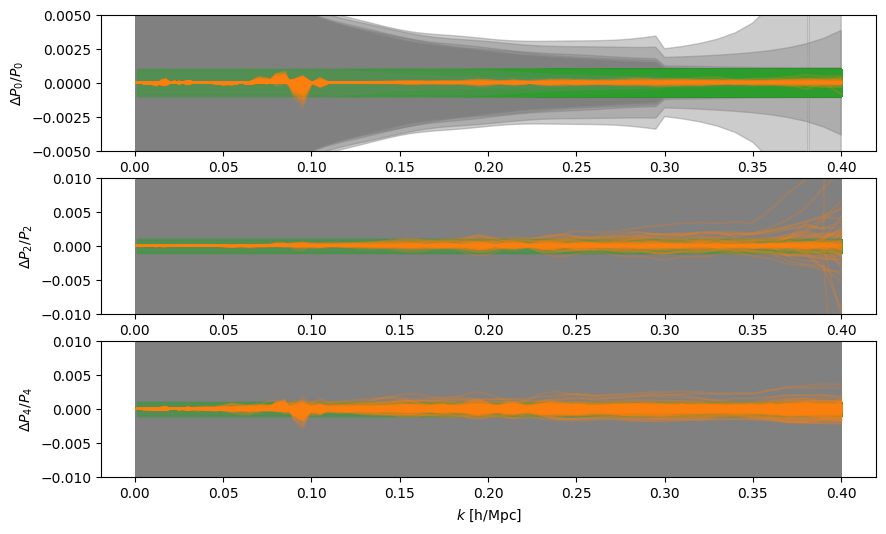

In [17]:
# make a plot where we loop through the samples and plot as a function of k

%matplotlib inline
plt.figure(figsize =(10,6))

fig, ax = plt.subplots(3,1,figsize =(10,6))
for i in range(n_samples):    
    reconstructed = bpk_reconstructed_array[i].reshape(3, -1)
    truth = bpk_array[i].reshape(3, -1)
    
    for j, ell in enumerate([0, 2, 4]):
        ax[j].fill_between(k_arr, -errs[i][j*77:(j+1)*77]/truth[j], errs[i][j*77:(j+1)*77]/truth[j], color='grey', alpha=.4, label='Spec-S4 error') 
        ax[j].fill_between(k_arr, -1e-3*np.ones_like(k_arr), 1e-3*np.ones_like(k_arr), color='C2', alpha=.3, label='Boltzmann code error')
        #reject the sample if the reconstructed power spectrum is negative

        if np.any(reconstructed[j] < 0):
            continue
        ax[j].plot(k_arr, (truth[j]-reconstructed[j])/truth[j], 'C1', alpha=0.2)

ax[0].set_ylabel(r'$\Delta P_0/P_0$')
ax[1].set_ylabel(r'$\Delta P_2/P_2$')
ax[2].set_ylabel(r'$\Delta P_4/P_4$')
ax[0].set_ylim(-0.005, 0.005)
ax[1].set_ylim(-0.01, 0.01)
ax[2].set_ylim(-0.01, 0.01)

ax[2].set_xlabel(r'$k$ [h/Mpc]')



### To get an object measure of the accuracy lets finally plot a histogram of the chi2s accross the bank

In [18]:
diff = bpk_reconstructed_array[:n_samples] - bpk_array[:n_samples]

In [19]:
diff.shape 

(1000, 231)

In [20]:
chi2_array = np.einsum('ni, nij, jn -> n', diff, inv_covs, diff.T)  

In [21]:
chi2_array.shape 

(1000,)

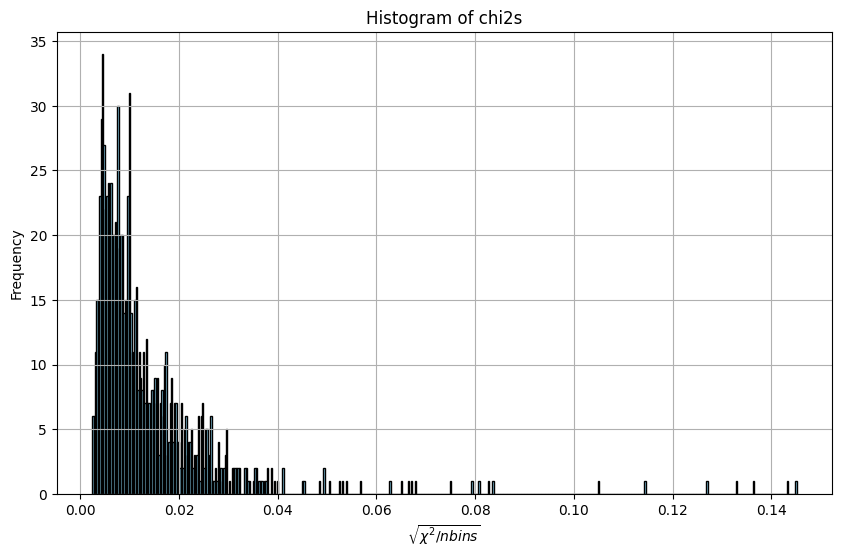

In [22]:
nbins=231
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.hist(np.sqrt(np.array(chi2_array)/nbins), bins=500, color='skyblue', edgecolor='black')
plt.title('Histogram of chi2s')
plt.xlabel(r'$\sqrt{\chi^2/nbins}$')
plt.ylabel('Frequency')
plt.grid(True)

### Lets make a grid plot similar to how we will measure accuracy for the emu itself 

In [23]:
err_array = np.array(errs)

In [28]:
grid = np.abs((bpk_reconstructed_array[:n_samples] - bpk_array[:n_samples]))/err_array

In [29]:
percentiles = np.zeros((4, 231))
percentiles[0] = np.percentile(grid, 68, axis = 0)
percentiles[1] = np.percentile(grid, 95, axis = 0)
percentiles[2] = np.percentile(grid, 99, axis = 0)
percentiles[3] = np.percentile(grid, 99.9, axis = 0)

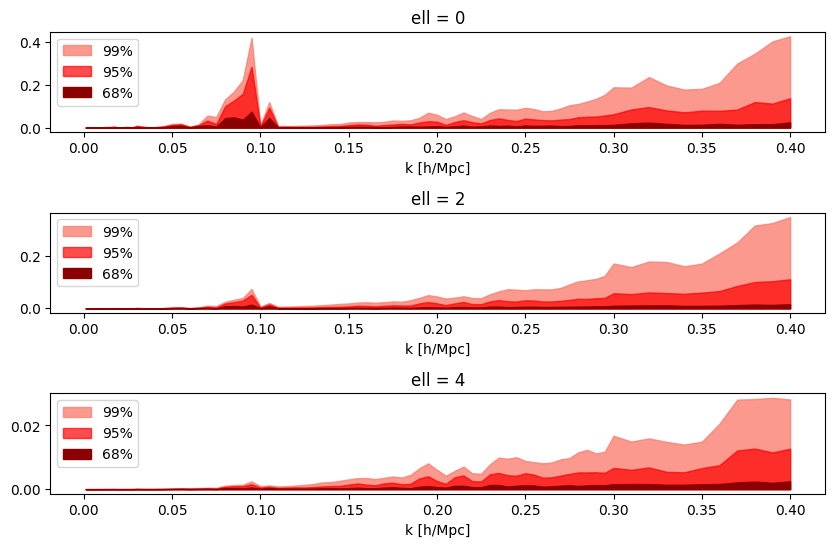

In [30]:
fig, ax = plt.subplots(3,1,figsize =(10,6))

# set some space between the subplots
fig.subplots_adjust(hspace=0.8)
for i in range(3):
    ax[i].fill_between(k_arr, 0, percentiles[2,77*i:77*(i+1)], color = 'salmon', label = '99%', alpha=0.8)
    ax[i].fill_between(k_arr, 0, percentiles[1,77*i:77*(i+1)], color = 'red', label = '95%', alpha = 0.7)
    ax[i].fill_between(k_arr, 0, percentiles[0,77*i:77*(i+1)], color = 'darkred', label = '68%', alpha = 1)
    ax[i].legend()
    ax[i].set_title(f"ell = {2*i}")
    ax[i].set_xlabel("k [h/Mpc]")
